In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, HTML
print_large = lambda x : display(HTML('<font size="3">'+x+'</font>'))
# 由于代码已经测试过了，所以选择忽略不必要的警告
import warnings
warnings.simplefilter("ignore")

In [2]:
class Problem:
    def __init__(self, dim = 2, alpha=0.1, beta=0.8, f=None, df=None, hessian=None):
        self.dim = dim
        self.alpha = alpha
        self.beta = beta
        self.tol = 1.0e-6
        self.ref_state = None # 若有真解，可以使用真解作为参照物
        self.condition = "grad" # 停止条件
        self.P = np.eye(dim) # 默认无坐标变换
        self.method = "gradient" # gradient or newton.
        self.f = f
        self.df = df
        self.hessian = hessian

    def backtracking_line_search(self, x, d):
        k = 0
        t = 1.0
        while self.f(x + t * d) > self.f(x) + t * self.alpha * np.dot(self.df(x), d):
            t *= self.beta
            k += 1
        return t, k
    
    def gradient_propose(self, x):
        if self.method == "gradient":
            P = self.P
        elif self.method == "newton":
            P = self.hessian(x)
        else:
            raise ValueError("method must be gradient or newton")
        return - np.linalg.solve(P, self.df(x))

    def update(self, x):
        # 迭代更新一步
        d = self.gradient_propose(x)
        t, _ = self.backtracking_line_search(x, d)
        return x + t * d, t
    
    # 此处，我们没有使用课本的牛顿法的停止条件，停止条件本身对于后续测试的关系不是特别大
    def stop_condition(self,x):
        if self.condition == "ref_state":
            return np.linalg.norm(x - self.ref_state) < self.tol
        elif self.condition == "grad":
            return np.linalg.norm(self.df(x)) < self.tol
        else:
            assert False, "use the correct one"
        
    def solve(self, x0, max_iter=100):
        t_begin = time.time()
        
        t_list = []
        x = x0.copy()
        trajectory_exact = [x.copy()]

        for i in range(max_iter):
            x, t_ = self.update(x) # t_ 是搜索得到的步长
            t_list.append(t_)
            trajectory_exact.append(x.copy())
            # 终止条件
            if self.stop_condition(x):
                break

        runtime = time.time() - t_begin
        return np.array(trajectory_exact), runtime, t_list
    
    def plot_contour(self, xmin, xmax, ymin, ymax):
        grid_x = np.linspace(xmin, xmax, 400)
        grid_y = np.linspace(ymin, ymax, 300)
        grid_X, grid_Y = np.meshgrid(grid_x, grid_y)
        Z = np.zeros((np.size(grid_X,0),np.size(grid_X,1)))
        
        for i in range(np.size(grid_X,0)):
            for j in range(np.size(grid_X,1)):
                Z[i,j] = self.f(np.array([grid_X[i,j], grid_Y[i,j]]))
    
        contour = plt.contourf(grid_X, grid_Y, Z, levels=20, cmap='Blues')
        plt.colorbar(contour)
        plt.xlabel(r'$x$', fontsize=12)
        plt.ylabel(r'$y$', fontsize=12)

## Example 1

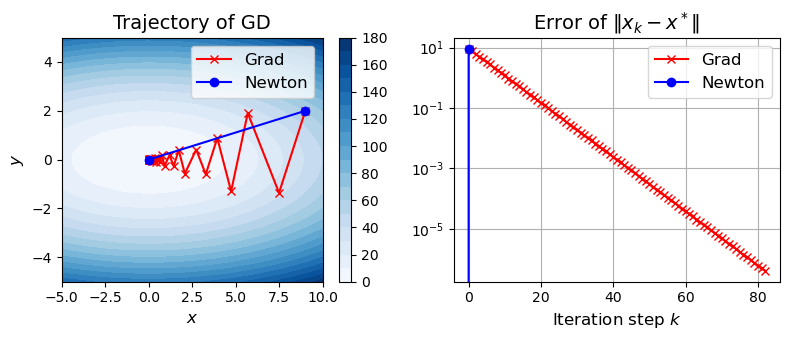

In [3]:
γ  = 10.0
f = lambda x : (x[0]**2 + γ * x[1]**2)/2
df = lambda x : np.array([x[0], γ*x[1]])
hessian = lambda x : np.array([[1,0],[0,γ]])
prob = Problem(f=f, df=df, hessian=hessian)
prob.alpha = 0.05
prob.beta = 0.7

x0 = np.array([9.0, 2.0])
xmin = -5; xmax = γ; ymin = -5; ymax = 5

prob.method = "gradient"
trajectory_gd, runtime, t_list_gd = prob.solve(x0)
print_large("梯度法使用了 {:.2f} ms".format(runtime*10**3))

prob.method = "newton"
trajectory_newton, runtime, t_list_newton = prob.solve(x0)
print_large("牛顿法使用了 {:.2f} ms".format(runtime*10**3))

print_large("梯度法使用了迭代次数：{:d}".format(len(trajectory_gd)))
print_large("牛顿法使用了迭代次数：{:d}".format(len(trajectory_newton)))

# Plot the results
plt.figure(figsize=(8, 3.5))
plt.subplot(1, 2, 1)
plt.plot(trajectory_gd[:, 0], trajectory_gd[:, 1], 'rx-', label='Grad')
plt.plot(trajectory_newton[:, 0], trajectory_newton[:, 1], 'bo-', label='Newton')

prob.plot_contour(xmin, xmax, ymin, ymax)
plt.title("Trajectory of GD", fontsize=14)
plt.legend(fontsize=12)

# 此处比较特殊，真解是 x = [0,0]
plt.subplot(1, 2, 2)
plt.plot(np.linalg.norm(trajectory_gd, ord=2, axis=1), 'rx-', label='Grad')
plt.plot(np.linalg.norm(trajectory_newton, ord=2, axis=1), 'bo-', label='Newton')

plt.yscale('log')
plt.title(r"Error of $\Vert x_k - x^* \Vert$", fontsize=14)
plt.xlabel(r"Iteration step $k$",fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()

plt.show()

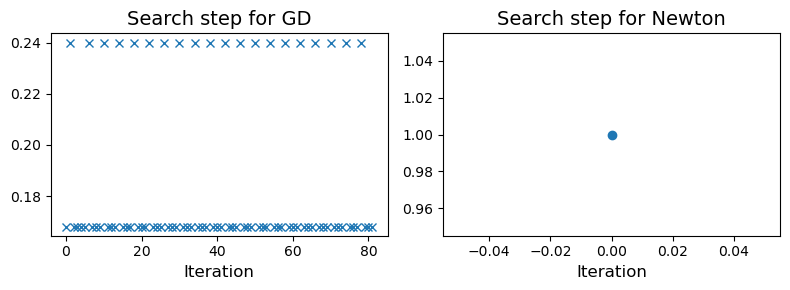

In [4]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t_list_gd, 'x')
plt.xlabel("Iteration",fontsize=12)
plt.title("Search step for GD",fontsize=14)

plt.subplot(1,2,2)
plt.plot(t_list_newton, 'o')
plt.xlabel("Iteration",fontsize=12)
plt.title("Search step for Newton",fontsize=14)

plt.tight_layout()

## 例子2
$$ f(x,y) =  e^{x + 3 y -0.1} + e^{x - 3y -0.1} + e^{-x-0.1}$$


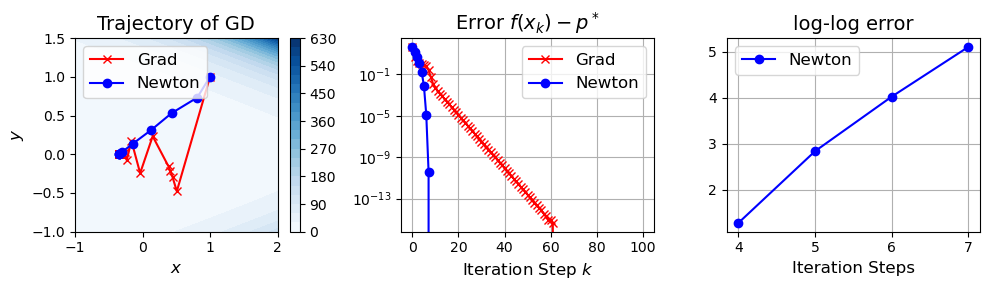

In [5]:
f = lambda x : np.exp(x[0]+3*x[1]-0.1) + np.exp(x[0] - 3*x[1]-0.1) + np.exp(-x[0]-0.1)
df = lambda x : np.array([np.exp(x[0]+3*x[1]-0.1) + np.exp(x[0] - 3*x[1]-0.1) - np.exp(-x[0]-0.1),
                           3*np.exp(x[0]+3*x[1]-0.1) - 3*np.exp(x[0] - 3*x[1]-0.1)])
hessian = lambda x : np.array([[np.exp(x[0]+3*x[1]-0.1) + np.exp(x[0] - 3*x[1]-0.1) + np.exp(-x[0]-0.1), 
                                3*np.exp(x[0]+3*x[1]-0.1) -3 * np.exp(x[0] - 3*x[1]-0.1)],
                                [3*np.exp(x[0]+3*x[1]-0.1) - 3*np.exp(x[0] - 3*x[1]-0.1),
                                 9*np.exp(x[0]+3*x[1]-0.1) + 9*np.exp(x[0] - 3*x[1]-0.1)]])

prob = Problem(f=f, df=df, hessian=hessian)
prob.alpha = 0.01
prob.beta = 0.1

x0 = np.array([1.0, 1.0])
xmin = -1; xmax = 2; ymin = -1; ymax = 1.5

# 该问题的真解未知
# 我们使用高精度的要求去得到高精度的近似解作为真解。
prob.tol = 1.0e-20
prob.method = "newton"
trajectory_newton_ref, runtime, _ = prob.solve(x0)
p_star = prob.f(trajectory_newton_ref[-1])
print_large("近似真解的计算过程使用了 {:.2f} ms".format(runtime*10**3))


prob.tol = 1.0e-10

prob.method = "gradient"
trajectory_gd, runtime, t_list_gd = prob.solve(x0)
print_large("梯度法使用了 {:.2f} ms".format(runtime*10**3))

prob.method = "newton"
trajectory_newton, runtime, t_list_newton = prob.solve(x0)
print_large("牛顿法使用了 {:.2f} ms".format(runtime*10**3))

print_large("梯度法使用了迭代次数：{:d}".format(len(trajectory_gd)))
print_large("牛顿法使用了迭代次数：{:d}".format(len(trajectory_newton)))

# Plot the results
plt.figure(figsize=(10, 3.0))
plt.subplot(1, 3, 1)
plt.plot(trajectory_gd[:,0], trajectory_gd[:,1], 'rx-', label='Grad')
plt.plot(trajectory_newton[:,0], trajectory_newton[:,1], 'bo-', label='Newton')

prob.plot_contour(xmin, xmax, ymin, ymax)
plt.title("Trajectory of GD", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(1, 3, 2)
plt.plot([prob.f(item) - p_star for item in trajectory_gd], 'rx-', label='Grad')
plt.plot([prob.f(item) - p_star for item in trajectory_newton], 'bo-', label='Newton')
plt.yscale('log')
plt.title(r"Error $f(x_k) - p^*$", fontsize=14)
plt.xlabel(r"Iteration Step $k$",fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot([np.log2(np.log2(1/(prob.f(item) - p_star))) for item in trajectory_newton], 'bo-', label='Newton')
plt.title("log-log error", fontsize=14)
plt.xlabel("Iteration Steps",fontsize=12)
plt.legend(fontsize=12)
plt.grid()

plt.tight_layout()
plt.show()

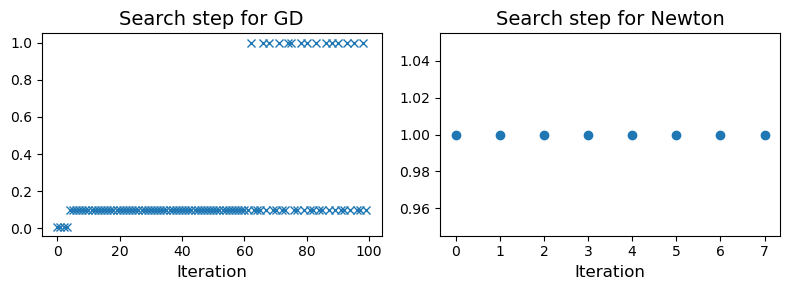

In [6]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(t_list_gd, 'x')
plt.title("Search step for GD",fontsize=14)
plt.xlabel("Iteration",fontsize=12)

plt.subplot(1,2,2)
plt.plot(t_list_newton, 'o')
plt.title("Search step for Newton",fontsize=14)
plt.xlabel("Iteration",fontsize=12)

plt.tight_layout()